In [1]:
seed = 0
import random
import numpy as np
import tensorflow as tf
import os
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["PYTHONHASHSEED"] = str(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import resample
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler


def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0


sample_num = 60

In [4]:
root_path  = '../../data/'
train = pd.read_csv(root_path+'sensor_train.csv')
test = pd.read_csv(root_path+'sensor_test.csv')
sub = pd.read_csv(root_path+'提交结果示例.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

In [5]:
def add_features(df):
    print(df.columns)
    df['acc'] = (df.acc_x ** 2 + df.acc_y ** 2 + df.acc_z ** 2) ** .5
    df['accg'] = (df.acc_xg ** 2 + df.acc_yg ** 2 + df.acc_zg ** 2) ** .5
    df['thetax']=np.arctan(df.acc_xg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetay']=np.arctan(df.acc_yg/
                           np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetaz']=np.arctan(df.acc_zg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi

    df['xy'] = (df['acc_x'] ** 2 + df['acc_y'] ** 2) ** 0.5
    df['xy_g'] = (df['acc_xg'] ** 2 + df['acc_yg'] ** 2) ** 0.5    
    
    df['g'] = ((df["acc_x"] - df["acc_xg"]) ** 2 + 
                 (df["acc_y"] - df["acc_yg"]) ** 2 + (df["acc_z"] - df["acc_zg"]) ** 2) ** 0.5

    print(df.columns)
    return df

In [6]:
train=add_features(train)
test=add_features(test)

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'acc', 'accg', 'thetax', 'thetay',
       'thetaz', 'xy', 'xy_g', 'g'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'acc', 'accg', 'thetax', 'thetay', 'thetaz', 'xy',
       'xy_g', 'g'],
      dtype='object')


In [7]:
group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
group1

['acc_x',
 'acc_y',
 'acc_z',
 'acc_xg',
 'acc_yg',
 'acc_zg',
 'acc',
 'accg',
 'thetax',
 'thetay',
 'thetaz',
 'xy',
 'xy_g',
 'g']

In [8]:
FEATURE_NUM=14

In [9]:

x = np.zeros((7292, sample_num, FEATURE_NUM, 1))
t = np.zeros((7500, sample_num, FEATURE_NUM, 1))

from scipy.fftpack import fft
from scipy.signal import resample
def get_fft_values(y_values, N, f_s):
    f_values = np.linspace(0.0, f_s/2.0, N//2)
    fft_values_ = fft(y_values)
    plt.plot(fft_values_)
    plt.show()
    print(fft_values_.shape)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    print(fft_values.shape)
    return f_values, fft_values

# tmp = train[train.fragment_id == 0][:sample_num]

# get_fft_values(tmp["acc"].values,60,5)

In [14]:

test['fragment_id'] += 10000
data = pd.concat([train, test], sort=False)
ss_tool = StandardScaler()
data[group1] = ss_tool.fit_transform(data[group1])
train = data[data["behavior_id"].isna()==False].reset_index(drop=True)
test = data[data["behavior_id"].isna()==True].reset_index(drop=True)
test['fragment_id'] -= 10000                         
train = train[['fragment_id', 'time_point', 'behavior_id']+group1]
test = test[['fragment_id', 'time_point']+group1]
print(train.columns)

for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:sample_num]
    x[i,:,:,0] = fft(resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1)[group1], sample_num, np.array(tmp.time_point))[0]).reshape(sample_num,FEATURE_NUM)
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:sample_num]
    t[i,:,:,0] = fft(resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1)[group1], sample_num, np.array(tmp.time_point))[0]).reshape(sample_num,FEATURE_NUM)

    
    

  0%|          | 0/7292 [00:00<?, ?it/s]/home/zhangqibot/miniconda3/envs/tf_2.1/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
  1%|          | 53/7292 [00:00<00:13, 522.55it/s]

Index(['fragment_id', 'time_point', 'behavior_id', 'acc_x', 'acc_y', 'acc_z',
       'acc_xg', 'acc_yg', 'acc_zg', 'acc', 'accg', 'thetax', 'thetay',
       'thetaz', 'xy', 'xy_g', 'g'],
      dtype='object')


100%|██████████| 7500/7500 [00:15<00:00, 494.80it/s]


In [15]:
def ConvBNRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
#                activation='relu',
               use_bias=False,
               padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X


def ConvRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
               activation='relu',
               use_bias=False,
               padding='same')(X)
    return X


def squeeze_excitation_layer(x, out_dim,ratio=8):
    '''
    SE module performs inter-channel weighting.
    '''
    squeeze = GlobalAveragePooling2D()(x)

    excitation = Dense(units=out_dim // ratio)(squeeze)
    excitation = Activation('relu')(excitation)
    excitation = Dense(units=out_dim)(excitation)
    excitation = Activation('sigmoid')(excitation)
    excitation = Reshape((1,1,out_dim))(excitation)
    scale = multiply([x,excitation])
    return scale

# def SE_Residual(X):
#     A = 
#     X = squeeze_excitation_layer(X,128)
#     X =  Add()([X,A])
    

def lenet5(input):
    A = ConvBNRelu(input,64,kernal_size=(3,3))
#     B = ConvBNRelu(input,16,kernal_size=(5,1))
#     C = ConvBNRelu(input,16,kernal_size=(7,1))
#     ABC = layers.Concatenate()([A,B,C])
    X = ConvBNRelu(A,128)
#     X = squeeze_excitation_layer(X,128)
    X = Dropout(0.2)(X)

    X = AveragePooling2D()(X)
    
    X = ConvBNRelu(X,256)
    X = Dropout(0.3)(X)
#     X = squeeze_excitation_layer(X,256)
    X = ConvBNRelu(X,512)   
    X = Dropout(0.5)(X)
#     X = squeeze_excitation_layer(X,512)
#     X = GlobalMaxPooling2D()(X)
    X = GlobalAveragePooling2D()(X)
    
#     X = BatchNormalization()(X)
    return X
import tensorflow as tf
def Net(sample_num):
    input1 = Input(shape=(sample_num, FEATURE_NUM, 1))
    part = tf.split(input1,axis=2, num_or_size_splits = [6, 2, 6])
#     res = tf.split(c, axis = 3, num_or_size_splits = [2, 2, 4])
    
    
    X1 = Concatenate(axis=-2)([part[0],part[1]])
    X1 = lenet5(X1)
    X1 = BatchNormalization()(X1)
    X1 = Dense(128, activation='relu')(X1)
    X1 = BatchNormalization()(X1)
    X1 = Dropout(0.2)(X1)

    X2 = Concatenate(axis=-2)([part[0],part[2]])
    X2 = lenet5(X2)    
    X2 = BatchNormalization()(X2)
#     X = Dense(512, activation='relu')(X)
#     X = BatchNormalization()(X)
    X2 = Dense(128, activation='relu')(X2)
    X2 = BatchNormalization()(X2)
    X2 = Dropout(0.2)(X2)
    
    X = Concatenate(axis=-1)([X1,X2])
    
#     X = Dense(256)(X)    
    
    output1 = Dense(4, activation='softmax', name='4class')(X)   # 大类-字母
#     output2 = Dense(128)(X)
#     output2 = Dense(64)(X)
    X = Dense(64)(X)
    output2 = Dense(7, activation='softmax', name='7class')(X)   # 大类-数字
#     X = Dense(32)(X)
#     X = Concatenate(axis=-1)([X,output1,output2])
    X = Dense(64)(X)
    output3 = Dense(19, activation='softmax',name='19class')(X) #小类
    
    
    return Model([input1], [output1,output2,output3])

model = Net(60)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 14, 1)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlow [(None, 60, 6, 1), ( 0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 60, 8, 1)     0           tf_op_layer_split_1[0][0]        
                                                                 tf_op_layer_split_1[0][1]        
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 60, 12, 1)    0           tf_op_layer_split_1[0][0]  

# dense
```
dense_158 (Dense)               (None, 256)          65792       concatenate_155[0][0]            
__________________________________________________________________________________________________
dense_159 (Dense)               (None, 128)          32896       dense_158[0][0]                  
__________________________________________________________________________________________________
dense_160 (Dense)               (None, 256)          33024       dense_159[0][0]                  
__________________________________________________________________________________________________
dense_161 (Dense)               (None, 128)          32896       dense_160[0][0]                  
_________________________________________________________________________________________________
```
[0.845, 0.838, 0.812, 0.822, 0.812] 0.8258000000000001    
[0.8671627664088236, 0.8639642285975372, 0.8386569991508248, 0.851459925533998, 0.8411065386374014] 0.8524700916657171  

-------------
```
    output1 = Dense(4, activation='softmax', name='4class')(X)   # 大类-字母
    X = Dense(128)(X)
    X = Dense(64)(X)
    output2 = Dense(7, activation='softmax', name='7class')(X)   # 大类-数字
    X = Dense(64)(X)
    X = Dense(32)(X)
    output3 = Dense(19, activation='softmax',name='19class')(X) #小类

```
0 val_4class_loss0.47757295val_4class_acc0.90472925
1 val_4class_loss0.42935628val_4class_acc0.91089785
2 val_4class_loss0.4260101val_4class_acc0.9238683
3 val_4class_loss0.4555293val_4class_acc0.8978052
4 val_4class_loss0.4219553val_4class_acc0.89711934
[0.819, 0.837, 0.857, 0.809, 0.817] 0.8278000000000001    
[0.8447077254479575, 0.8621038545644417, 0.877914951989024, 0.8381344307270219, 0.8430988307531503] 0.8531919586963191    


-------

```
#     X = Dense(19)(X)    
    
    output1 = Dense(4, activation='softmax', name='4class')(X)   # 大类-字母
#     X = Dense(128)(X)
    X = Dense(64)(X)
    output2 = Dense(7, activation='softmax', name='7class')(X)   # 大类-数字
    X = Dense(64)(X)
#     X = Dense(32)(X)
    output3 = Dense(19, activation='softmax',name='19class')(X) #小类
```
[0.808, 0.836, 0.855, 0.814, 0.824] 0.8274000000000001   
[0.8357322366917967, 0.8609941577727713, 0.875628715134886, 0.8447971781305103, 0.8481612123587412] 0.8530627000177411  
线上0.796

------------------

```
    X = Concatenate(axis=-1)([X1,X2])
    
#     X = Dense(256)(X)    
    
    output1 = Dense(4, activation='softmax', name='4class')(X)   # 大类-字母
#     output2 = Dense(128)(X)
#     output2 = Dense(64)(X)
    X = Dense(64)(X)
    output2 = Dense(7, activation='softmax', name='7class')(X)   # 大类-数字
#     X = Dense(64)(X)
#     X = Dense(32)(X)
#     X = Concatenate(axis=-1)([X,output1,output2])
    X = Dense(64)(X)
    output3 = Dense(19, activation='softmax',name='19class')(X) #小类

```
[0.814, 0.833, 0.85, 0.829, 0.841] 0.8333999999999999       
[0.8404974052677944, 0.859982375403895, 0.8727545888039693, 0.8554118492390083, 0.8649487229734123] 0.8587189883376158     

-----------
```
    X = Concatenate(axis=-1)([X1,X2])
    
#     X = Dense(256)(X)    
    
    output1 = Dense(4, activation='softmax', name='4class')(X)   # 大类-字母
#     output2 = Dense(128)(X)
#     output2 = Dense(64)(X)
    X = Dense(128)(X)
    output2 = Dense(7, activation='softmax', name='7class')(X)   # 大类-数字
#     X = Dense(64)(X)
#     X = Dense(32)(X)
#     X = Concatenate(axis=-1)([X,output1,output2])
    X = Dense(128)(X)
    output3 = Dense(19, activation='softmax',name='19class')(X) #小类
    
```

[0.851, 0.825, 0.855, 0.821, 0.844] 0.8392     
[0.8736903945951223, 0.8528019843989669, 0.8762819256646396, 0.8497615781566383, 0.8669083545626737] 0.8638888474756083     

线上 78938



---------------------------------------------------
```
    X = Concatenate(axis=-1)([X1,X2])
    
#     X = Dense(256)(X)    
    
    output1 = Dense(4, activation='softmax', name='4class')(X)   # 大类-字母
#     output2 = Dense(128)(X)
#     output2 = Dense(64)(X)
    X = Dense(64)(X)
    output2 = Dense(7, activation='softmax', name='7class')(X)   # 大类-数字
#     X = Dense(32)(X)
#     X = Concatenate(axis=-1)([X,output1,output2])
    X = Dense(64)(X)
    output3 = Dense(19, activation='softmax',name='19class')(X) #小类
    
    
    return Model([input1], [output1,output2,output3])

```
[0.85, 0.839, 0.845, 0.829, 0.837] 0.8399999999999999    
[0.8721564019713419, 0.8632788276379759, 0.8670063361421364, 0.8551505650271063, 0.8620092755895202] 0.8639202812736162    
线上  789999999


第二次跑 

[0.845, 0.809, 0.842, 0.81, 0.823] 0.8257999999999999


[0.8656940500669066, 0.8366134664969463, 0.865536612450191, 0.8416617675876923, 0.8489124044679585] 0.8516836602139388

第三次跑
固定种子

[0.85, 0.826, 0.845, 0.835, 0.845] 0.8402

[0.8700022846698634, 0.8540095956134318, 0.8693578940492505, 0.8598863413678212, 0.867594225618915] 0.8641700682638562



In [16]:
# 两个输出    
mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
16: 'C_2', 17: 'C_5', 18: 'C_6'}
# 每一个大类输出 4
new_mapping = {'A':0,'B':1,'C':2,'D':3}

from sklearn.utils.class_weight import compute_class_weight
# y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights1=compute_class_weight("balanced",['A','B','C','D'],\
                                   pd.read_csv(root_path+'sensor_train.csv')['behavior_id'].apply(lambda x:mapping[x][0]))
classweights1=pd.DataFrame(classweights1)[0].to_dict()



classweights2=compute_class_weight("balanced",list(range(7)),\
                                   pd.read_csv(root_path+'sensor_train.csv')['behavior_id'].apply(lambda x:int(mapping[x][2])))
classweights2=pd.DataFrame(classweights2)[0].to_dict()



from sklearn.utils.class_weight import compute_class_weight
# y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights3=compute_class_weight("balanced",np.array(range(19)), pd.read_csv(root_path+'sensor_train.csv')['behavior_id'])
classweights3=pd.DataFrame(classweights3)[0].to_dict()
classweights1,classweights2,classweights3

({0: 0.7453285438934641,
  1: 0.7866762590992484,
  2: 0.8681079382183908,
  3: 4.251549256356949},
 {0: 1.757195321956318,
  1: 0.4815479398086302,
  2: 0.9616022823865589,
  3: 1.1412232173040497,
  4: 2.4294567179182565,
  5: 1.2367567913331454,
  6: 0.8210787010495146},
 {0: 1.6146639588513296,
  1: 0.5658077637797579,
  2: 0.9428223116223914,
  3: 1.1544614165363905,
  4: 0.895063001338305,
  5: 1.120093850476494,
  6: 0.5129293816036677,
  7: 1.6147804233607677,
  8: 1.1629774436090226,
  9: 1.3287818013695207,
  10: 1.639495846903968,
  11: 0.8571276001942526,
  12: 0.5209381219191084,
  13: 1.3164363042146117,
  14: 3.1705588145409553,
  15: 0.8020390423628304,
  16: 1.108447580802777,
  17: 1.4649467209444893,
  18: 1.12076674790857})

In [17]:
# [:,:,:,[1]]
train = x
test = t

fold_num=5
kfold = StratifiedKFold(fold_num,random_state=42,shuffle=True)
proba_t = np.zeros((7500, 19))
proba_oof = np.zeros((7292,19))

oof_score = []
oof_comm = []
history = []

from tensorflow.keras.losses import categorical_crossentropy
def custom_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)

# 两个输出    
mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
16: 'C_2', 17: 'C_5', 18: 'C_6'}
# 每一个大类输出 4
new_mapping = {'A':0,'B':1,'C':2,'D':3}
y_1 = to_categorical([new_mapping[mapping[x][0]] for x in y], num_classes=4)
# 每一个大类输出 
new_mapping = {'A':0,'B':1,'C':2,'D':3}
y_2 = to_categorical([mapping[x][2] for x in y], num_classes=7)
# 每一个小类的输出 19
y_3 = to_categorical(y, num_classes=19)


for fold, (xx, yy) in enumerate(kfold.split(train, y)):

    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
    4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
    8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
    12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
    16: 'C_2', 17: 'C_5', 18: 'C_6'}
    new_mapping = {'A':0,'B':1,'C':2,'D':3}
    
    model = Net(60)
    model.summary()
    model.compile(loss=[custom_loss,custom_loss,custom_loss],loss_weights=[3,7,21],
                  optimizer=Adam(),
                  metrics=["acc"])#'',localscore
    plateau = ReduceLROnPlateau(monitor="19class_acc",
                                verbose=1,
                                mode='max',
                                factor=0.5,
                                patience=18)
    early_stopping = EarlyStopping(monitor="val_19class_acc",
                                   verbose=1,
                                   mode='max',
                                   patience=60)
#     file_path = save_dir + f'/fold{fold}' + '_weights_{epoch:02d}_{val_loss:.2f}_{val_acc:.2f}.h5'
#     checkpoint = ModelCheckpoint(file_path,
#                     monitor='val_acc',
#                     verbose=1,
#                     mode='max',
#                     save_best_only=False)    # 保存所有的
    checkpoint = ModelCheckpoint(f'Conv2d_multiloss_fold{fold}.h5',
                                 monitor="val_19class_acc",
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
 
    train_res = model.fit(train[xx], [y_1[xx], y_2[xx], y_3[xx]],
              epochs=1000,
              batch_size=32,
              verbose=1,
              shuffle=True,
              validation_data=(train[yy], [y_1[yy], y_2[yy],y_3[yy]]),
              callbacks=[plateau, early_stopping, checkpoint],
                         class_weight=[classweights1,classweights2,classweights3])
    history.append(train_res)
    
    
#     # 找到对应最高的 val_acc 对应的epoch，预测left+1+right次
#     left=2
#     right=2
#     max_acc_index=history[fold].history['val_acc'].index(np.max(history[fold].history['val_acc']))+1

#     save_filelist=os.listdir(save_dir)
#     save_filelist.sort()
#     select_blending=save_filelist[max_acc_index-left : max_acc_index+right]
#     print(select_blending)
#     for file in select_blending:
#         model.load_weights(save_dir+'/'+file)
#         proba_t += model.predict(t, verbose=0, batch_size=1024) / (fold_num*len(select_blending))
#         proba_oof[yy] = model.predict(train[yy],verbose=0,batch_size=1024) / len(select_blending)
    
    model.load_weights(f'Conv2d_multiloss_fold{fold}.h5')
    proba_t += model.predict(test, verbose=0, batch_size=1024)[2] / fold_num 
    proba_oof[yy] += model.predict(train[yy],verbose=0,batch_size=1024) [2]

    oof_y = np.argmax(proba_oof[yy], axis=1)
    acc = round(accuracy_score(y[yy], oof_y),3)
    print(acc)
    oof_score.append(acc)
    scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y[yy], oof_y)) / oof_y.shape[0]
    oof_comm.append(scores)   
    print(round(scores, 5))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 14, 1)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split_2 (TensorFlow [(None, 60, 6, 1), ( 0           input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 60, 8, 1)     0           tf_op_layer_split_2[0][0]        
                                                                 tf_op_layer_split_2[0][1]        
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 60, 12, 1)    0           tf_op_layer_split_2[0][0]  

In [21]:
for index,i in enumerate(oof_comm):
    print(index,i,oof_score[index])

oof_dict = {
    "oof":proba_oof,
    "test":proba_t,
    "acc":oof_comm,
}
import joblib 
joblib.dump(oof_dict,"spetron0728_conv2_2_net_multiloss_%.5f_dict.pkl"% np.mean(oof_comm))


0 0.8363523613694946 0.809
1 0.8408890629589724 0.813
2 0.8565223071395892 0.831
3 0.8376445228297067 0.809
4 0.8410085570579379 0.813


['spetron0728_conv2_2_net_multiloss_0.84248_dict.pkl']

0.84024
0.86417


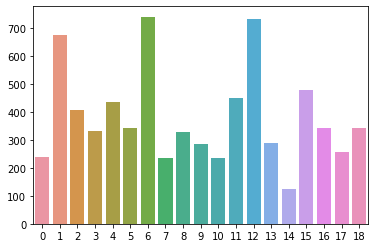

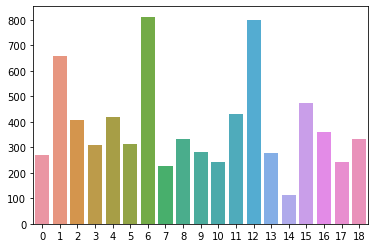

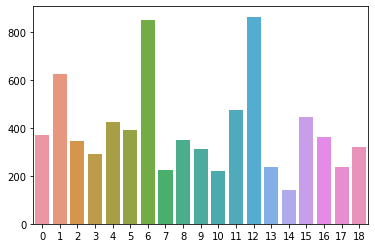

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   fragment_id  7500 non-null   int64
 1   behavior_id  7500 non-null   int64
dtypes: int64(2)
memory usage: 117.3 KB


In [26]:

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

train_y = y
labels = np.argmax(proba_t, axis=1)
oof_y = np.argmax(proba_oof, axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(scores, 5))
data_path = '../../data/'
sub = pd.read_csv(data_path+'提交结果示例.csv')
sub['behavior_id'] = labels

vc = pd.Series(train_y).value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()

vc = pd.Series(oof_y).value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()

vc = sub['behavior_id'].value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()
sub.to_csv('0728_conv2_multoloss_nn%.5f.csv' % scores, index=False)
sub.info()
